# Figure 1

In this notebook, we'll generate figure panels for use in Figure 1.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
ggrastr: raster plotting for ggplot2  
cowplot: multi-panel plot assembly  
Seurat: single-cell genomics methods  
ArchR: single-cell ATAC-seq methods

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrastr)
quiet_library(cowplot)
quiet_library(Seurat)
quiet_library(ArchR)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
out_dir <- "output/figure_1"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the Seurat objects and cell type labels based on file UUIDs. This will be placed in the `cache/` subdirectory by default.

In [3]:
so_uuids <- list(
    "7bdac6ef-e5e5-4150-b4f3-9c1a1e250334", # CD4 T cell Seurat object
    "46438bc4-cde6-4ae6-b349-9c513dd9d16f" # CD8 T cell Seurat object
)

In [4]:
so_res <- cacheFiles(so_uuids)
so_files <- list.files(
    paste0("cache/",so_uuids),
    recursive = TRUE, full.names = TRUE
)

[1] "Initiating file download for filtered_cd4_te_seurat.rds"
[1] "Download successful."
[1] "Initiating file download for filtered_cd8_te_seurat.rds"
[1] "Download successful."


In [5]:
label_uuids <- list(
    "ebd4bee7-2f5d-46e1-b2fc-22157f1b8d04", # CD4 type labels
    "4d6aade9-288c-452f-8f0d-ac59e539f4cc"  # CD8 type labels
)

In [6]:
label_res <- cacheFiles(label_uuids)
label_files <- list.files(
    paste0("cache/",label_uuids),
    recursive = TRUE, full.names = TRUE
)

[1] "Initiating file download for cd4_cell_type_labels_2023-09-05.csv"
[1] "Download successful."
[1] "Initiating file download for cd8_cell_type_labels_2023-09-05.csv"
[1] "Download successful."


In [7]:
arrow_uuids <- list(
    "052b769d-cbdf-41f6-8fe8-0d34564b442a",
    "16e0c562-5d36-431f-bb27-b443aabc7077",
    "30167a93-70a8-4c38-b615-2252dabe417e",
    "57dde81e-bdaa-4138-add6-2551968672f4",
    "6853fb68-fa85-43d5-9071-c5e42667a75e",
    "6d8185bf-8a35-492d-a6ab-5783006b3b8e",
    "8c2a93be-de53-4d6f-ae2e-ab40a356edc3",
    "9ab975f8-7763-4892-96a7-a7438ecc9470",
    "a56fd2ba-a055-4ff8-9ab1-69df113bc032",
    "ad2f347d-e961-4a70-b294-4df83c12355d",
    "c299a55a-3325-4eb3-ba8e-c8ceccafaa8c",
    "ff8fe67e-cfe0-482a-bad1-aa189390a1c0"
)

In [8]:
arrow_res <- cacheFiles(arrow_uuids)
arrow_files <- list.files(
    paste0("cache/",arrow_uuids),
    recursive = TRUE, full.names = TRUE
)

[1] "Initiating file download for EXP-00454-P1_PC02184-038_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-040_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-041_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-039_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-045_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-046_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-048_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-044_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-043_archr.arrow"
[1] "Download successful."
[1] "Initiating file download for EXP-00454-P1_PC02184-049_archr.arrow"
[1] "Download successful."
[1] "Initi

## UMAP Projections

To generate UMAPs that provide an overview of the effect of treatment, we'll sample an equal number of cells from each condition.

We'll use this sampling to select cells from our scATAC-seq data, then perform ArchR's IterativeLSI method to obtain reduced dimensions for scATAC.

Then, we'll perform dimensionality reduction using Seurat's methods for scRNA-seq and ADT data.

Once we have all 3 modalities, we can integrate them using Seurat's Weighted Nearest Neighbors methods to generate a joint UMAP projection.

### Select cells

In [9]:
all_labels <- map_dfr(label_files, read.csv)

For this figure, we'll leave out the untreated cells

In [10]:
all_labels <- all_labels %>%
  filter(treatment != "untreated")

In [11]:
sample_counts <- all_labels %>%
    group_by(treatment, timepoint) %>%
    dplyr::summarise(n_cells = n(),
                     .groups = "keep")

In [12]:
sample_counts

treatment,timepoint,n_cells
<chr>,<int>,<int>
bortezomib,4,14679
bortezomib,24,17139
bortezomib,72,4858
dexamethasone,4,27353
dexamethasone,24,4260
dmso,4,10819
dmso,24,22177
dmso,72,2920
lenalidomide,4,5738


The sample with the fewest cells is DMSO at 72 hr. To balance the samples, let's use 2,500 cells per sample for visualization.

In [13]:
n_downsample <- 2500

In [14]:
set.seed(3030)
sampled_labels <- all_labels %>%
  group_by(treatment, timepoint) %>%
  sample_n(n_downsample) %>%
  ungroup()

In [15]:
nrow(all_labels)
nrow(sampled_labels)

[1] 128605

[1] 27500

Split cells by timepoint

In [16]:
split_labels <- split(sampled_labels, sampled_labels$timepoint)

### Run ArchR LSI

In [17]:
addArchRThreads(12)
addArchRGenome("hg38")
addArchRVerbose(FALSE)

Setting default number of Parallel threads to 12.

Setting default genome to Hg38.

Setting addArchRVerbose = FALSE



In [18]:
all_proj <- ArchRProject(
    ArrowFiles = arrow_files,
    copyArrows = FALSE,
    showLogo = FALSE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...



In [19]:
split_proj <- map2(
    split_labels, names(split_labels),
    function(sampled_labels, tp) {
        archr_meta <- as.data.frame(getCellColData(all_proj))
        sampled_archr_meta <- archr_meta %>%
          mutate(archr_name = rownames(archr_meta)) %>%
          filter(barcodes %in% sampled_labels$barcodes)
        
        sampled_proj <- subsetArchRProject(
            all_proj,
            cells = sampled_archr_meta$archr_name,
            outputDirectory = paste0("SampledArchR_", tp)
        )
    }
)

Copying ArchRProject to new outputDirectory : /home/jupyter/repro-vrd-tea-seq/figures/SampledArchR_4

Copying Arrow Files...

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-==================

In [20]:
split_proj <- map(split_proj, addIterativeLSI)

Checking Inputs...

Checking Inputs...

Checking Inputs...



Extract LSI dimensions and match the order of cells to the sampled metadata

In [21]:
lsi_mats <- map2(
    split_proj, split_labels,
    function(sampled_proj, sampled_labels) {
        lsi_mat <- getReducedDims(sampled_proj)
        rownames(lsi_mat) <- sub(".+#", "", rownames(lsi_mat))
        lsi_mat <- lsi_mat[sampled_labels$barcodes,]
        lsi_mat
    }
)

Save LSI results

In [22]:
walk2(
    lsi_mats, names(split_labels),
    function(lsi_mat, tp) {
        saveRDS(
            lsi_mat,
            file.path(out_dir, paste0("atac_lsi_mat_", tp, "_", Sys.Date(), ".rds"))
        )
    }
)

### Run Seurat PCA for scRNA

In [23]:
cd4_so <- readRDS(so_files[1])
all_cd4_meta <- cd4_so@meta.data
cd4_so <- cd4_so[,cd4_so$barcodes %in% sampled_labels$barcodes]
cd8_so <- readRDS(so_files[2])
all_cd8_meta <- cd4_so@meta.data
cd8_so <- cd8_so[,cd8_so$barcodes %in% sampled_labels$barcodes]

In [24]:
all_meta <- rbind(all_cd4_meta, all_cd8_meta)

In [25]:
sampled_so <- merge(cd4_so, cd8_so)

In [26]:
sampled_so

An object of class Seurat 
36656 features across 27500 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ADT

Split by timepoint

In [27]:
split_so <- map(
    split_labels,
    function(labels) {
        sampled_so[,labels$barcodes]
    }
)

In [28]:
split_so <- map(
    split_so,
    function(sampled_so) {
        DefaultAssay(sampled_so) <- "RNA"
        sampled_so <- FindVariableFeatures(sampled_so, nfeatures = 5000)
        sampled_so <- NormalizeData(sampled_so)
        sampled_so <- ScaleData(sampled_so)
        sampled_so <- RunPCA(
            sampled_so, 
            reduction.name = "rnapca",
            reduction.key = "RNAPC_")
        sampled_so
    }
)

Centering and scaling data matrix

RNAPC_ 1 
Positive:  NIBAN1, SRGN, ARAP2, ADAM19, ANXA2, SAMSN1, NEAT1, ERN1, CD58, PTMA 
	   SIK3, MAF, IQGAP2, KLF6, ANXA1, CREM, RORA, ITGB1, PHACTR2, HSP90AA1 
	   SLA, ZEB2, LMNA, RNF19A, CCL5, TENT5C, ID2, SLAMF1, TGFBR3, ZFP36L2 
Negative:  TXK, IGF1R, PLCL1, MYB, MLLT3, BCL2, LEF1, MALAT1, KLF7, PDK1 
	   UBE2E2, CERS6, SCML1, FKBP5, SFMBT2, DACT1, IKZF1, MBNL1, RIPOR2, KANK1 
	   ATM, PTK2, HIVEP1, SATB1-AS1, PSMA1, MAN1C1, LRRN3, CA6, RALGAPA2, RAPGEF6 
RNAPC_ 2 
Positive:  SOS1, RIPOR2, ADAM19, ARID5B, INPP4B, ARHGAP15, MDFIC, ATXN1, MBNL1, IKZF1 
	   PAG1, ANK3, ARHGAP25, CDC42SE2, CASK, PHTF2, MFHAS1, MAP3K1, GPRIN3, ANTXR2 
	   ARAP2, ADK, PHACTR2, CMTM6, GNAQ, TBC1D5, TNIK, ZBTB20, CHST11, ELMO1 
Negative:  GADD45B, NR4A2, DUSP2, CCL5, TSC22D3, FOSB, FOS, NFKBIA, ID2, DNAJB1 
	   UBE2S, TUBB4B, JUNB, IER5L, RGCC, DUSP1, MYADM, SERTAD1, DNAJA1, ZEB2 
	   KLRD1, ZFP36, NR4A3, IER2, DDIT4, JUN, NKG7, HSPA1B, H3F3B, LMNA 
RNAPC_ 3 
Positive

### Run Seurat PCA for ADT

In [29]:
split_so <- map(
    split_so,
    function(sampled_so) {
        DefaultAssay(sampled_so) <- "ADT"
        sampled_so <- NormalizeData(
            sampled_so, 
            normalization.method = "CLR", 
            margin = 2) # normalize across cells
        
        var_feats <- rownames(sampled_so)
        var_veats <- var_feats[!grepl("Control", rownames(sampled_so))]
        VariableFeatures(sampled_so) <- var_feats
        
        sampled_so <- ScaleData(sampled_so)
        sampled_so <- RunPCA(
            sampled_so, 
            npcs = 20, 
            ndims.print = 1,
            reduction.name = "adtpca",
            reduction.key = "ADTPC_")
        
        sampled_so
    }
)

Normalizing across cells

Centering and scaling data matrix

Warning message:
“Requested number is larger than the number of available items (55). Setting to 55.”
ADTPC_ 1 
Positive:  CD95, CD45RO, CD4, CD49d, CD161, CD71, CD278, CD69, CD196, CD25 
	   CD39, CD194, HLA.DR, CD11c, TIGIT, CD27, CD279, CD127, CD183, CD11b 
	   CD57, CD244, CD86, CD103, CD28, CD152, KLRG1, CD26 
Negative:  CD45RA, CD8a, CD38, CD197, TCR.VA24.JA18.iNKT.cell, CD24, TCR.G.D, CX3CR1, CD172a, IgG1.K.Isotype.Control 
	   CD80, CD319, CD40, TCR.A.B, CD134, CD366, CD85j, CD192, CD154, CD294 
	   CD56, CD21, CD304, CD16, CD137, CD185, TCR.Va7.2 

Normalizing across cells

Centering and scaling data matrix

Warning message:
“Requested number is larger than the number of available items (55). Setting to 55.”
ADTPC_ 1 
Positive:  CD95, CD45RO, CD4, CD196, CD49d, CD25, CD194, CD161, CD278, CD183 
	   CD69, CD28, TIGIT, CD39, CD71, CD279, CD127, CD134, CD26, TCR.A.B 
	   CD27, CD11c, HLA.DR, CD57, CD244, KLRG1, CD103, C

### Add ATAC LSI to Seurat Objects

In [30]:
split_so <- map2(
    split_so, lsi_mats,
    function(so, lsi_mat) {
        lsi_mat <- lsi_mat[so$barcodes,]
        
        # Spoofing counts using the LSI matrix
        # we don't actually need counts, but we need Seurat to have an ATAC assay.
        
        so[["ATAC"]] <- CreateAssayObject(
            counts = t(lsi_mat)
        )
        
        atac_rd <- CreateDimReducObject(
            embeddings = lsi_mat,
            assay = "ATAC",
            key = "ATACLSI_"
        )
        so@reductions$ataclsi <- atac_rd
        so
    }
)

### Run WNN

In [31]:
n_lsi <- map(lsi_mats, ncol)

In [32]:
split_so <- map2(
    split_so, n_lsi,
    function(so, nlsi) {
        FindMultiModalNeighbors(
            so, 
            knn.graph.name = "wknn.tea",
            snn.graph.name = "wsnn.tea",
            weighted.nn.name = "weighted.nn.tea",
            reduction.list = c("rnapca", "adtpca", "ataclsi"),
            dims.list = list(1:30, 1:15, 1:nlsi),
        )
    }
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



### Run UMAP

In [33]:
split_so <- map(
    split_so,
    function(so) {
        RunUMAP(
            so, 
            nn.name = "weighted.nn.tea", 
            reduction.name = "umap_wnn_tea", 
            reduction.key = "wnnteaUMAP_"
        )
    }
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
03:21:20 UMAP embedding parameters a = 0.9922 b = 1.112

03:21:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

03:21:23 Initializing from normalized Laplacian + noise (using irlba)

03:21:23 Commencing optimization for 500 epochs, with 303466 positive edges

03:21:37 Optimization finished

03:21:37 UMAP embedding parameters a = 0.9922 b = 1.112

03:21:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

03:21:40 Initializing from normalized Laplacian + noise (using irlba)

03:21:40 Commencing optimization for 500 epochs, with 302146 positive edges

03:21:54 Optimization finished

03:21:54 UMAP embedding parameters a = 0.992

### Extract and plot UMAPs

In [34]:
umap_dfs <- map2(
    split_so, split_labels,
    function(so, labels) {
        umap_df <- as.data.frame(so@reductions$umap_wnn_tea@cell.embeddings)
        names(umap_df) <- c("UMAP_1", "UMAP_2")
        umap_df$barcodes <- rownames(umap_df)
        rownames(umap_df) <- NULL
        
        umap_df <- umap_df %>%
          left_join(labels)
        
        umap_df %>%
          select(barcodes, treatment, timepoint, aifi_cell_type, UMAP_1, UMAP_2)
    }
)

Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`


In [35]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")
type_colors <- type_colors %>%
  select(aifi_cell_type, cell_type_color)
treat_colors <- read.csv("../common/color_sets/treatment_colors.csv")
treat_colors <- treat_colors %>%
  select(treatment, treatment_color)

In [36]:
umap_dfs <- map(umap_dfs, left_join, type_colors)
umap_dfs <- map(umap_dfs, left_join, treat_colors)

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(treatment)`
Joining with `by = join_by(treatment)`


In [37]:
walk2(
    umap_dfs, names(umap_dfs),
    function(umap_df, tp) {
        write.csv(
            umap_df,
            file.path(out_dir, paste0("umap_projection_", tp, "_", Sys.Date(), ".csv"))
        )
    }
)

In [38]:
plot_treat_time <- function(
    plot_df, 
    invx = FALSE, invy = FALSE,
    focus_col = "treatment", focus_grps = NULL,
    drop_bg = FALSE
) {
    if(invx) {
        plot_df$UMAP_1 <- -1 * plot_df$UMAP_1
    }
    if(invy) {
        plot_df$UMAP_2 <- -1 * plot_df$UMAP_2
    }
    
    if(!is.null(focus_grps)) {
        fg_df <- plot_df[plot_df[[focus_col]] %in% focus_grps,]
        bg_df <- plot_df[!plot_df[[focus_col]] %in% focus_grps,]
    } else {
        fg_df <- plot_df
        bg_df <- NULL
    }
    
    p <- ggplot()
    
    if(!is.null(bg_df) & !drop_bg) {
        p <- p + geom_point_rast(
          data = bg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1,
          alpha = 0
        )
    }
    
    p <- p +
      geom_point_rast(
          data = fg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1
      ) +
      scale_x_continuous("") +
      scale_y_continuous("") +
      scale_color_identity() +
      theme_bw() +
      theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid.minor = element_blank(),
            plot.margin = margin(0,0,0,0))
}
plot_cell_types <- function(
    plot_df, 
    invx = FALSE, invy = FALSE,
    focus_col = "treatment", focus_grps = NULL,
    drop_bg = FALSE
) {
    if(invx) {
        plot_df$UMAP_1 <- -1 * plot_df$UMAP_1
    }
    if(invy) {
        plot_df$UMAP_2 <- -1 * plot_df$UMAP_2
    }
    
    if(!is.null(focus_grps)) {
        fg_df <- plot_df[plot_df[[focus_col]] %in% focus_grps,]
        bg_df <- plot_df[!plot_df[[focus_col]] %in% focus_grps,]
    } else {
        fg_df <- plot_df
        bg_df <- NULL
    }
    
    p <- ggplot()
    
    if(!is.null(bg_df) & !drop_bg) {
        p <- p + geom_point_rast(
          data = bg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1,
          alpha = 0
        )
    }
    
    p <- p +
      geom_point_rast(
          data = fg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = cell_type_color),
          size = 0.1
      ) +
      scale_x_continuous("") +
      scale_y_continuous("") +
      scale_color_identity() +
      theme_bw() +
      theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid.minor = element_blank(),
            plot.margin = margin(0,0,0,0))
}

Randomize point order for plots so we don't end up with layering of treatments.

In [39]:
plot_dfs <- map(
    umap_dfs,
    function(df) {
        df[sample(1:nrow(df), nrow(df)),]
    }
)

In [40]:
treat_plots <- map(plot_dfs, plot_treat_time)
type_plots <- map(plot_dfs, plot_cell_types)

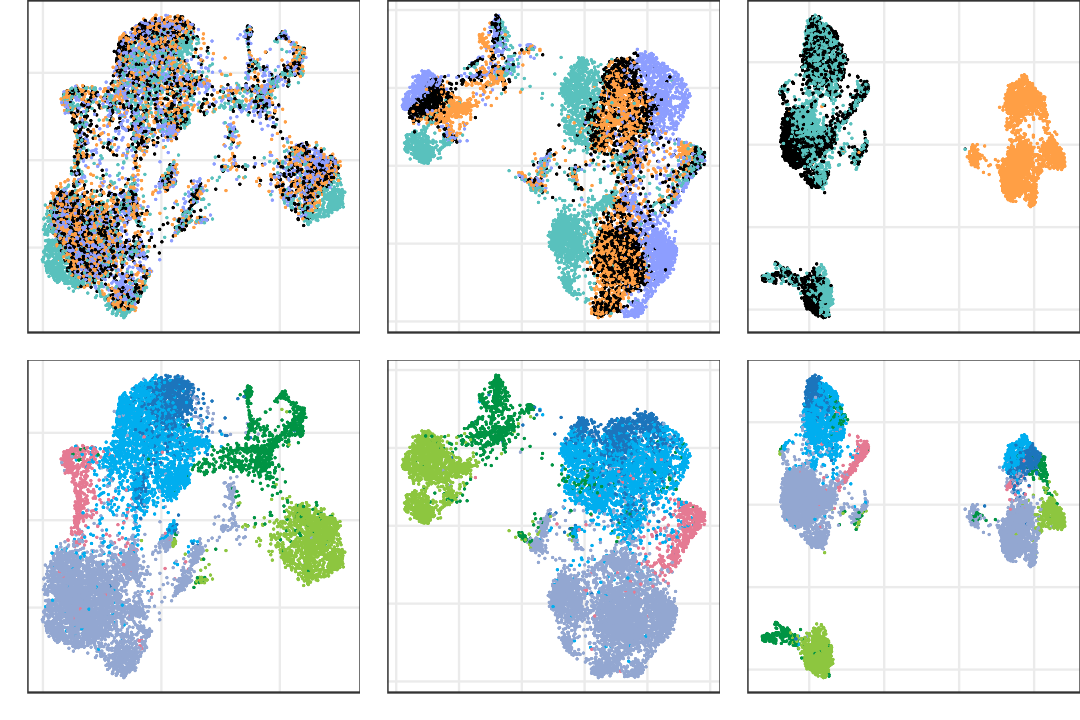

In [41]:
options(repr.plot.width = 9, repr.plot.height = 6)
all_plots <- plot_grid(
    plotlist = c(treat_plots, type_plots),
    nrow = 2, ncol = 3
)
all_plots

In [42]:
ggsave(
    file.path(out_dir, paste0("umap_plots_", Sys.Date(), ".pdf")),
    all_plots,
    width = 9, height = 6
)

For other figures, we'll want subsets of these cells displayed. Let's build those for each treatment condition here:

In [43]:
fg <- c("dmso", "bortezomib")

In [44]:
treat_plots <- map(plot_dfs, plot_treat_time, focus_grps = fg)
type_plots <- map(plot_dfs, plot_cell_types, focus_grps = fg)

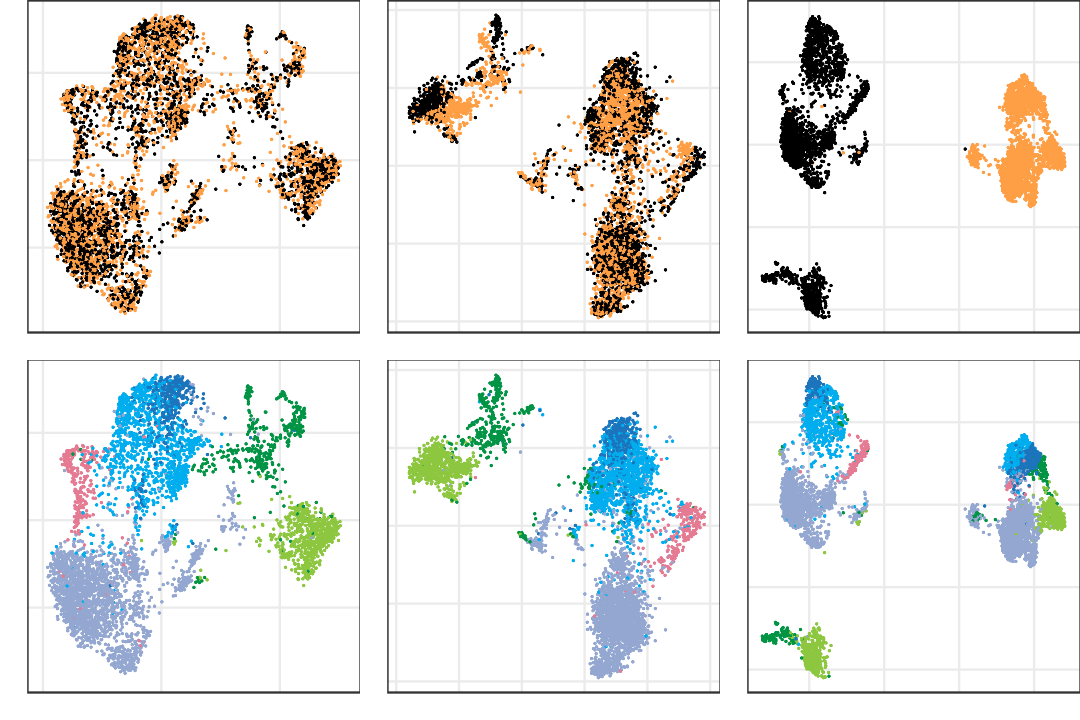

In [45]:
all_plots <- plot_grid(
    plotlist = c(treat_plots, type_plots),
    nrow = 2, ncol = 3
)
all_plots

In [46]:
ggsave(
    file.path(out_dir, paste0("umap_plots_bortezomib_", Sys.Date(), ".pdf")),
    all_plots,
    width = 9, height = 6
)

In [47]:
fg <- c("dmso", "lenalidomide")

In [48]:
treat_plots <- map(plot_dfs, plot_treat_time, focus_grps = fg, drop_bg = TRUE)
type_plots <- map(plot_dfs, plot_cell_types, focus_grps = fg, drop_bg = TRUE)

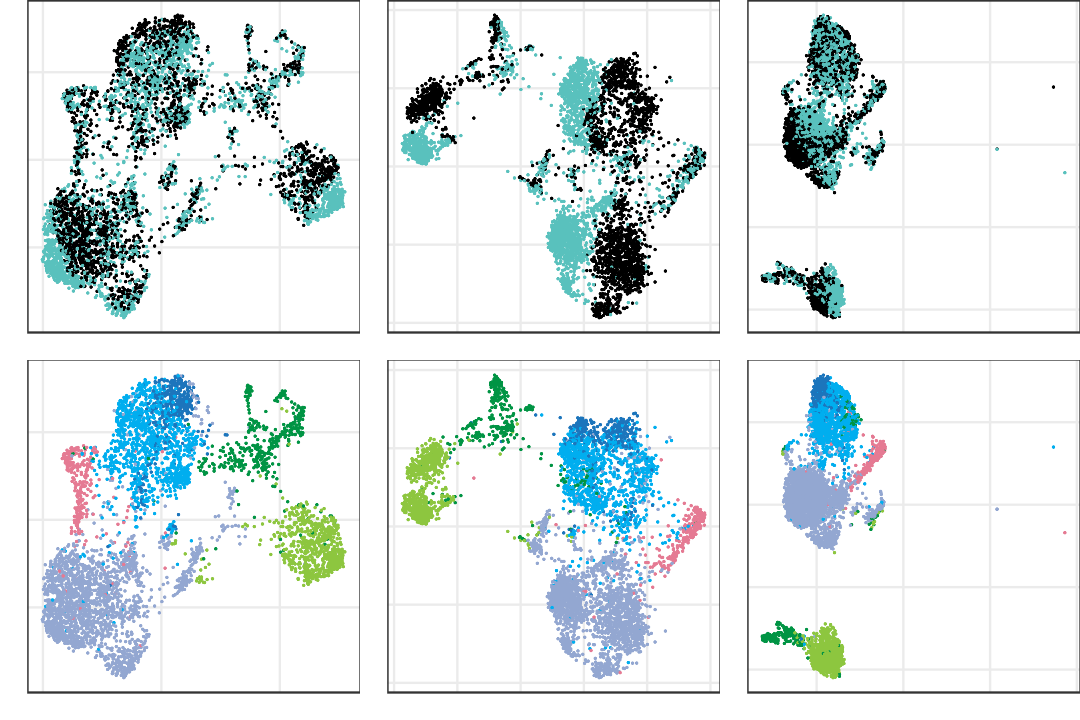

In [49]:
options(repr.plot.width = 9, repr.plot.height = 6)
all_plots <- plot_grid(
    plotlist = c(treat_plots, type_plots),
    nrow = 2, ncol = 3
)
all_plots

In [50]:
ggsave(
    file.path(out_dir, paste0("umap_plots_lenalidomide_", Sys.Date(), ".pdf")),
    all_plots,
    width = 9, height = 6
)

In [51]:
fg <- c("dmso", "dexamethasone")

In [52]:
treat_plots <- map(plot_dfs[c("4", "24")], plot_treat_time, focus_grps = fg)
type_plots <- map(plot_dfs[c("4", "24")], plot_cell_types, focus_grps = fg)

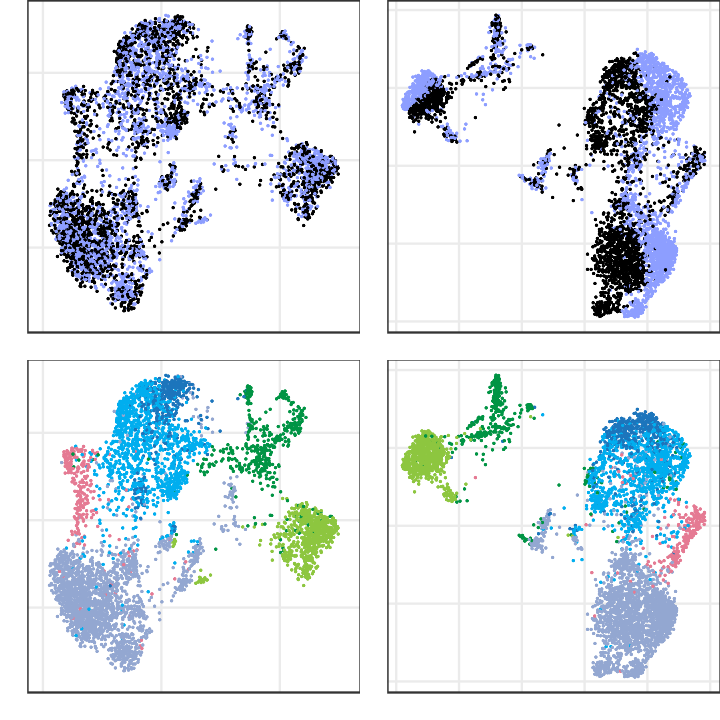

In [53]:
options(repr.plot.width = 6, repr.plot.height = 6)
all_plots <- plot_grid(
    plotlist = c(treat_plots, type_plots),
    nrow = 2, ncol = 2
)
all_plots

In [54]:
ggsave(
    file.path(out_dir, paste0("umap_plots_dexamethasone_", Sys.Date(), ".pdf")),
    all_plots,
    width = 6, height = 6
)

## QC violin Plots

To plot QC values, we'll use all cells per condition so the plots are representative of the full samples.

In [55]:
tt_pos <- data.frame(
    treat_time = c(
        "dmso_4", "bortezomib_4", "lenalidomide_4", "dexamethasone_4",
        "dmso_24", "bortezomib_24", "lenalidomide_24", "dexamethasone_24",
        "dmso_72", "bortezomib_72", "lenalidomide_72"
    ),
    treat_label = c(
        "DMSO 4 hr", "Bor. 4 hr", "Len. 4 hr", "Dex. 4 hr",
        "DMSO 24 hr", "Bor. 24 hr", "Len. 24 hr", "Dex. 24 hr",
        "DMSO 72 hr", "Bor. 72 hr", "Len. 72 hr"
    ),
    xpos = c(1,2,3,4,
             6,7,8,9,
             11,12,13),
    treatment_color = c(
        "#000000", "#FF9F45", "#59C1BD", "#8D9EFF",
        "#00000C", "#F29344", "#60CCC4", "#889DF2",
        "#000019", "#E58B41", "#54B2AB"
    )
)

In [56]:
plot_data <- all_meta %>%
  filter(treatment != "untreated") %>%
  mutate(
      treat_time = paste0(treatment, "_", timepoint),
      log_n_genes = log10(n_genes),
      log_n_adt_umis = log10(adt_umis),
      log_n_unique = log10(n_unique)
  ) %>%
  left_join(tt_pos)

Joining with `by = join_by(treat_time)`


In [57]:
write.csv(
    plot_data, 
    file.path(out_dir, paste0("qc_violin_plots_data_", Sys.Date(), ".csv")),
    row.names = FALSE, quote = FALSE
)

In [58]:
plot_meds <- plot_data %>%
  group_by(treat_time, xpos) %>%
  dplyr::summarise(
      med_n_genes = median(n_genes),
      med_n_adt_umis = median(adt_umis),
      med_n_unique = median(n_unique),
      med_log_n_genes = median(log_n_genes),
      med_log_n_adt_umis = median(log_n_adt_umis),
      med_log_n_unique = median(log_n_unique),
      .groups = "keep"
  ) %>%
  mutate(color = ifelse(grepl("dmso", treat_time), "white", "black"))

In [59]:
write.csv(
    plot_meds, 
    file.path(out_dir, paste0("qc_violin_plots_median_values_", Sys.Date(), ".csv")),
    row.names = FALSE, quote = FALSE
)

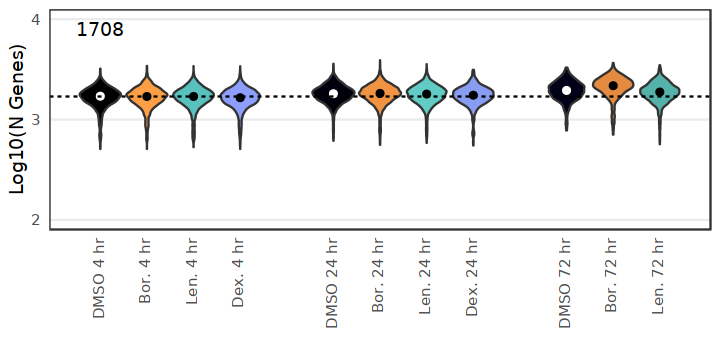

In [60]:
options(repr.plot.width = 6, repr.plot.height = 3)

genes <- ggplot() +
  geom_violin(
      data = plot_data,
      aes(x = xpos,
          y = log_n_genes,
          fill = treatment_color)
  ) +
  geom_point(
      data = plot_meds,
      aes(x = xpos,
          y = med_log_n_genes,
          color = color)
  ) +
  geom_hline(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(yintercept = med_log_n_genes),
      linetype = "dashed"
  ) +
  geom_text(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(x = 1, y = 3.9, label = med_n_genes)
  ) +
  scale_x_continuous(
      "",
      breaks = tt_pos$xpos,
      labels = tt_pos$treat_label
  ) +
  scale_color_identity() +
  scale_fill_identity() +
  scale_y_continuous("Log10(N Genes)",
                     limits = c(2, 4),
                     breaks = c(2,3,4)) +
  theme_bw() +
  theme(axis.ticks = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())
genes

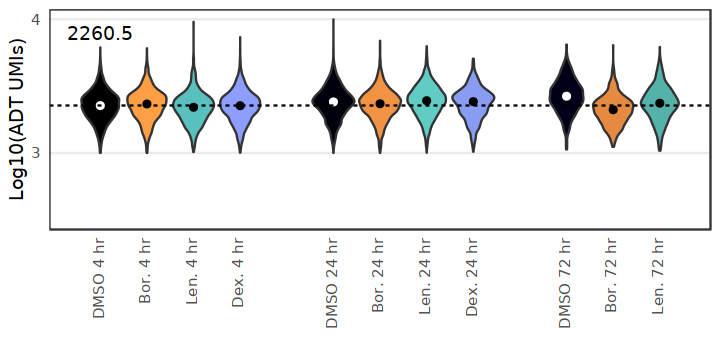

In [61]:
options(repr.plot.width = 6, repr.plot.height = 3)
adt <- ggplot() +
  geom_violin(
      data = plot_data,
      aes(x = xpos,
          y = log_n_adt_umis,
          fill = treatment_color)
  ) +
  geom_point(
      data = plot_meds,
      aes(x = xpos,
          y = med_log_n_adt_umis,
          color = color)
  ) +
  geom_text(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(x = 1, y = 3.9, label = med_n_adt_umis)
  ) +
  geom_hline(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(yintercept = med_log_n_adt_umis),
      linetype = "dashed"
  ) +
  scale_x_continuous(
      "",
      breaks = tt_pos$xpos,
      labels = tt_pos$treat_label
  ) +
  scale_color_identity() +
  scale_fill_identity() +
  scale_y_continuous("Log10(ADT UMIs)",
                     limits = c(2.5, 4),
                     breaks = c(2,3,4)) +
  theme_bw() +
  theme(axis.ticks = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())
adt

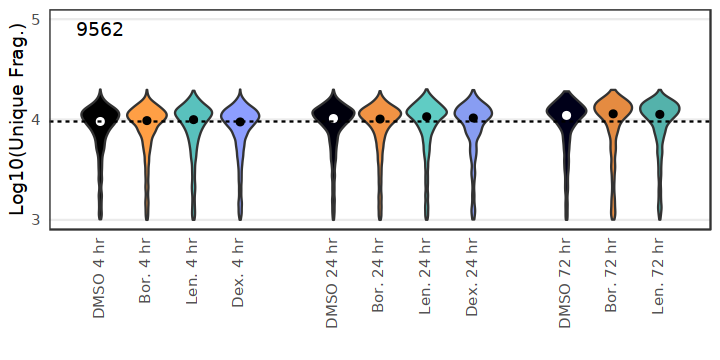

In [62]:
options(repr.plot.width = 6, repr.plot.height = 3)
atac <- ggplot() +
  geom_violin(
      data = plot_data,
      aes(x = xpos,
          y = log_n_unique,
          fill = treatment_color)
  ) +
  geom_point(
      data = plot_meds,
      aes(x = xpos,
          y = med_log_n_unique,
          color = color)
  ) +
  geom_text(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(x = 1, y = 4.9, label = med_n_unique)
  ) +
  geom_hline(
      data = plot_meds %>%
        filter(treat_time == "dmso_4"),
      aes(yintercept = med_log_n_unique),
      linetype = "dashed"
  ) +
  scale_x_continuous(
      "",
      breaks = tt_pos$xpos,
      labels = tt_pos$treat_label
  ) +
  scale_color_identity() +
  scale_fill_identity() +
  scale_y_continuous("Log10(Unique Frag.)",
                     limits = c(3, 5),
                     breaks = c(3,4,5)) +
  theme_bw() +
  theme(axis.ticks = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())
atac

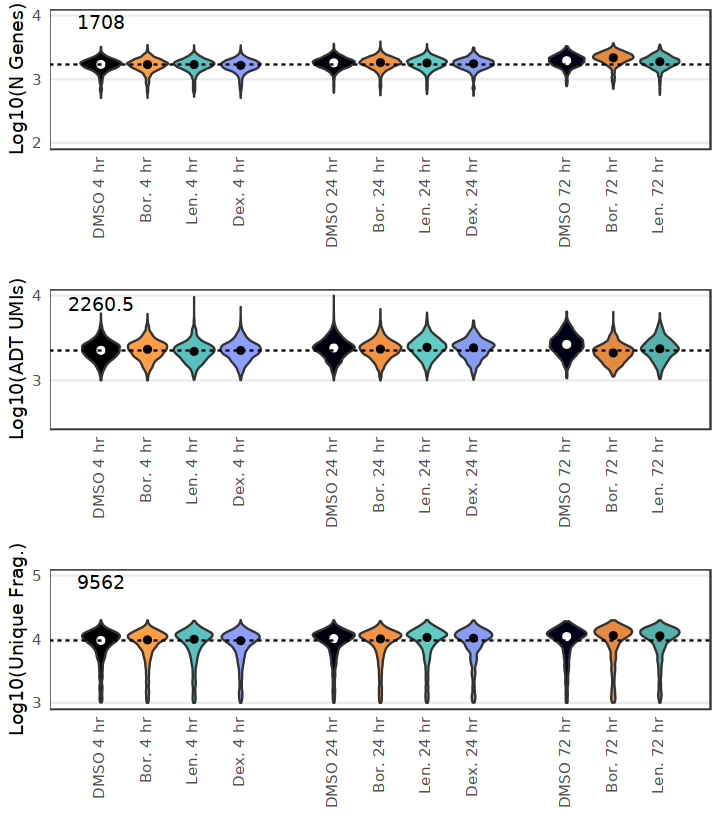

In [63]:
options(repr.plot.width = 6, repr.plot.height = 7)
all_plots <- plot_grid(
    genes, adt, atac,
    ncol = 1
)
all_plots

In [64]:
ggsave(
    file.path(out_dir, paste0("qc_violin_plots_", Sys.Date(), ".pdf")),
    all_plots,
    width = 6, height = 7
)

## Cell Type Stacked Barplots

In [65]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")
type_colors <- type_colors %>%
  select(aifi_cell_type, cell_type_ypos, cell_type_color)

In [66]:
label_summary <- all_labels %>%
  filter(treatment != "untreated") %>%
  mutate(treat_time = paste0(treatment, "_", timepoint)) %>%
  group_by(treat_time) %>%
  dplyr::mutate(total_n = n()) %>%
  ungroup() %>%
  group_by(treat_time, total_n, aifi_cell_type) %>%
  dplyr::summarise(n_cells = n(),
            frac_cells = n() / total_n[1],
            .groups = "keep")

In [67]:
plot_data <- label_summary %>%
  left_join(type_colors) %>%
  left_join(tt_pos) %>%
  arrange(cell_type_ypos) %>%
  group_by(treat_time) %>%
  dplyr::mutate(ymax = cumsum(frac_cells)) %>%
  dplyr::mutate(ymin = lag(ymax, default = 0)) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(treat_time)`


In [68]:
write.csv(
    plot_data, 
    file.path(out_dir, paste0("aifi_cell_type_stacked_barplot_data_", Sys.Date(), ".csv")),
    row.names = FALSE, quote = FALSE
)

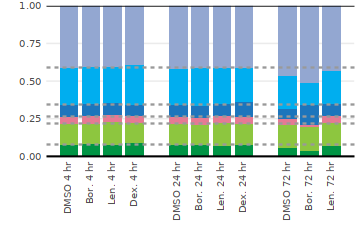

In [69]:
options(repr.plot.width = 3, repr.plot.height = 2)

type_barplots <- ggplot() +
  geom_rect(
      data = plot_data,
      aes(xmin = xpos - 0.4,
          xmax = xpos + 0.4,
          ymin = ymin,
          ymax = ymax,
          fill = cell_type_color)
  ) +
  geom_hline(
      data = plot_data %>%
        filter(treat_time == "dmso_4") %>%
        filter(ymax != 1),
      aes(yintercept = ymax),
      linetype = "dashed",
      color = "gray60"
  ) +
  geom_hline(
      data = data.frame(y = c(0,1)),
      aes(yintercept = y)
  ) +
  scale_x_continuous(
      "",
      breaks = tt_pos$xpos,
      labels = tt_pos$treat_label
  ) +
  scale_y_continuous(
      "",
      expand = c(0,0)
  ) +
  scale_fill_identity() +
  theme_bw(base_size = 7) +
  theme(
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      axis.ticks = element_blank(),
      panel.border = element_blank()
  )
type_barplots

In [70]:
ggsave(
    file.path(out_dir, paste0("aifi_cell_type_stacked_barplot_", Sys.Date(), ".pdf")),
    type_barplots,
    width = 3, height = 2
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [71]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Figure 1", Sys.Date())

In [72]:
out_files <- list.files(
    "output/figure_1",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [73]:
out_list

[[1]]
[1] "output/figure_1/aifi_cell_type_stacked_barplot_2023-10-17.pdf"

[[2]]
[1] "output/figure_1/aifi_cell_type_stacked_barplot_data_2023-10-17.csv"

[[3]]
[1] "output/figure_1/atac_lsi_mat_24_2023-10-17.rds"

[[4]]
[1] "output/figure_1/atac_lsi_mat_4_2023-10-17.rds"

[[5]]
[1] "output/figure_1/atac_lsi_mat_72_2023-10-17.rds"

[[6]]
[1] "output/figure_1/qc_violin_plots_2023-10-17.pdf"

[[7]]
[1] "output/figure_1/qc_violin_plots_data_2023-10-17.csv"

[[8]]
[1] "output/figure_1/qc_violin_plots_median_values_2023-10-17.csv"

[[9]]
[1] "output/figure_1/umap_plots_2023-10-17.pdf"

[[10]]
[1] "output/figure_1/umap_plots_bortezomib_2023-10-17.pdf"

[[11]]
[1] "output/figure_1/umap_plots_dexamethasone_2023-10-17.pdf"

[[12]]
[1] "output/figure_1/umap_plots_lenalidomide_2023-10-17.pdf"

[[13]]
[1] "output/figure_1/umap_projection_24_2023-10-17.csv"

[[14]]
[1] "output/figure_1/umap_projection_4_2023-10-17.csv"

[[15]]
[1] "output/figure_1/umap_projection_72_2023-10-17.csv"

In [74]:
in_list <- c(
    so_uuids, label_uuids, arrow_uuids
)

In [75]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/repro-vrd-tea-seq/figures/Fig-1_umap_qc-stats.ipynb"
[1] "2) /home/jupyter/repro-vrd-tea-seq/figures/Fig-2_bor_overview.ipynb"
[1] "3) /home/jupyter/repro-vrd-tea-seq/figures/Figure-R_diff_barplots (1).ipynb"


Please select (1-3)  1


[1] "Authorization token invalid or expired."
[1] "Retrying..."


$files
$files[[1]]
[1] "output/figure_1/aifi_cell_type_stacked_barplot_2023-10-17.pdf"

$files[[2]]
[1] "output/figure_1/aifi_cell_type_stacked_barplot_data_2023-10-17.csv"

$files[[3]]
[1] "output/figure_1/atac_lsi_mat_24_2023-10-17.rds"

$files[[4]]
[1] "output/figure_1/atac_lsi_mat_4_2023-10-17.rds"

$files[[5]]
[1] "output/figure_1/atac_lsi_mat_72_2023-10-17.rds"

$files[[6]]
[1] "output/figure_1/qc_violin_plots_2023-10-17.pdf"

$files[[7]]
[1] "output/figure_1/qc_violin_plots_data_2023-10-17.csv"

$files[[8]]
[1] "output/figure_1/qc_violin_plots_median_values_2023-10-17.csv"

$files[[9]]
[1] "output/figure_1/umap_plots_2023-10-17.pdf"

$files[[10]]
[1] "output/figure_1/umap_plots_bortezomib_2023-10-17.pdf"

$files[[11]]
[1] "output/figure_1/umap_plots_dexamethasone_2023-10-17.pdf"

$files[[12]]
[1] "output/figure_1/umap_plots_lenalidomide_2023-10-17.pdf"

$files[[13]]
[1] "output/figure_1/umap_projection_24_2023-10-17.csv"

$files[[14]]
[1] "output/figure_1/umap_projection_4_2023-10-17.csv"

$files[[15]]
[1] "output/figure_1/umap_projection_72_2023-10-17.csv"


$traceId
[1] "2e793a06-857e-4980-8c8d-1ec9fb64b0b5"

In [76]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] uwot_0.1.16                       BSgenome.Hsapiens.UCSC.hg38_1.4.5
 [3] BSgenome_1.68.0                   rtracklayer_1.60.1               
 [5] Biostrings_2.68.1              